In [4]:
!pip install mlflow scikit-learn seaborn matplotlib pandas joblib streamlit

In this project, the goal is to **predict cardiovascular disease (cardio = 0/1)** using patient demographic, clinical, and lifestyle data from the `cardio_train.csv` dataset. This supports doctors and hospitals by identifying high‑risk patients earlier so they can prioritize check‑ups and interventions.

#Problem Framing :
Define this as a binary classification** task with `cardio` as the target variable. The model predicts whether a patient is likely to have cardiovascular disease.
#Business Understanding :
The model aims to improve patient outcomes and resource allocation by focusing on patients with high predicted risk. Recall and ROC‑AUC are prioritized to catch as many positive cases as possible while maintaining good overall discrimination.
#Stakeholder Alignment :
Stakeholders include doctors, hospital management, and data/IT teams. Doctors need interpretable results (key risk factors), management cares about impact and reliability, and IT needs a deployable model (API/function).
#Planning :
The notebook is structured to follow a full ML lifecycle: data ingestion → validation → EDA → cleaning → feature engineering → modeling & tuning → evaluation → packaging → deployment plan → monitoring & retraining → documentation & reporting.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import joblib
import mlflow
import mlflow.sklearn
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid", context="notebook")
RANDOM_STATE = 42

# Cardiovascular Disease Prediction

**Business objective**: Predict whether a patient has cardiovascular disease (`cardio` = 0/1) using demographic, clinical, and lifestyle information (age, gender, height, weight, blood pressure, cholesterol, glucose, smoking, alcohol, activity). This helps prioritize high‑risk patients for further examination.

**ML task**: Binary classification.

**Key metrics**: Recall, Precision, F1‑score, ROC‑AUC, plus confusion matrix.


#Data Collection :
The dataset `cardio_train.csv` is a pre‑collected cardiovascular dataset containing patient records with features like age (in days), gender, height, weight, blood pressure, cholesterol, glucose, smoking, alcohol, physical activity, and the target `cardio`.
#Data Ingestion :
The next code cell reads the raw CSV file into a pandas DataFrame and creates a working copy. This is the ETL/ELT step where data moves from storage into the analysis environment.
#Data Validation :
After loading, the notebook inspects column names, data types, and basic statistics to ensure the structure matches expectations.
#Data Quality Checks (8):
The notebook checks for missing values, duplicates, and unrealistic ranges (e.g., negative or extreme heights, weights, and invalid blood pressure where diastolic > systolic). These checks identify potential issues that must be handled before modeling.


In [6]:
data_raw = pd.read_csv("cardio_train.csv", sep=';')
data = data_raw.copy()
print("Shape:", data.shape)
data.head()

Shape: (49961, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0.0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1.0
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1.0
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1.0
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0.0


In [7]:
data.info()
display(data.describe(include="all").T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49961 entries, 0 to 49960
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           49961 non-null  int64  
 1   age          49961 non-null  int64  
 2   gender       49961 non-null  int64  
 3   height       49961 non-null  int64  
 4   weight       49961 non-null  float64
 5   ap_hi        49961 non-null  int64  
 6   ap_lo        49961 non-null  int64  
 7   cholesterol  49961 non-null  int64  
 8   gluc         49961 non-null  int64  
 9   smoke        49961 non-null  int64  
 10  alco         49961 non-null  int64  
 11  active       49961 non-null  int64  
 12  cardio       49960 non-null  float64
dtypes: float64(2), int64(11)
memory usage: 5.0 MB


,count,mean,std,min,25%,50%,75%,max
id,49961.0,35676.161566,20609.537461,0.0,17836.0,35682.0,53508.0,71310.0
age,49961.0,19464.684094,2469.041025,10798.0,17662.0,19703.0,21321.0,23690.0
gender,49961.0,1.346971,0.476011,1.0,1.0,1.0,2.0,2.0
height,49961.0,164.366166,8.190134,55.0,159.0,165.0,170.0,250.0
weight,49961.0,74.230610,14.327859,11.0,65.0,72.0,82.0,200.0
ap_hi,49961.0,128.747183,154.515534,-150.0,120.0,120.0,140.0,16020.0
ap_lo,49961.0,96.972118,200.225599,0.0,80.0,80.0,90.0,11000.0
cholesterol,49961.0,1.363504,0.677197,1.0,1.0,1.0,1.0,3.0
gluc,49961.0,1.225856,0.572023,1.0,1.0,1.0,1.0,3.0
smoke,49961.0,0.088209,0.283601,0.0,0.0,0.0,0.0,1.0


In [8]:
print("Missing values per column:")
data.isna().sum()
print("\nNumber of duplicate rows:", data.duplicated().sum())

Missing values per column:

Number of duplicate rows: 0


In [9]:
print("Columns:", list(data.columns))
expected_cols = [
    "id", "age", "gender", "height", "weight",
    "ap_hi", "ap_lo", "cholesterol", "gluc",
    "smoke", "alco", "active", "cardio"
]
missing = set(expected_cols) - set(data.columns)
print("Missing expected columns:", missing)

Columns: ['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']
Missing expected columns: set()


In [10]:
data["age_years"] = data["age"] / 365.25

print("Age in years summary:")
print(data["age_years"].describe())

print("\nHeight summary:")
print(data["height"].describe())

print("\nWeight summary:")
print(data["weight"].describe())

print("\nSystolic (ap_hi) summary:")
print(data["ap_hi"].describe())

print("\nDiastolic (ap_lo) summary:")
print(data["ap_lo"].describe())

invalid_bp = data[(data["ap_hi"] < data["ap_lo"]) | (data["ap_hi"] <= 0) | (data["ap_lo"] <= 0)]
print("\nRows with invalid blood pressure:", invalid_bp.shape[0])

Age in years summary:
count    49961.000000
mean        53.291401
std          6.759866
min         29.563313
25%         48.355921
50%         53.943874
75%         58.373717
max         64.859685
Name: age_years, dtype: float64

Height summary:
count    49961.000000
mean       164.366166
std          8.190134
min         55.000000
25%        159.000000
50%        165.000000
75%        170.000000
max        250.000000
Name: height, dtype: float64

Weight summary:
count    49961.000000
mean        74.230610
std         14.327859
min         11.000000
25%         65.000000
50%         72.000000
75%         82.000000
max        200.000000
Name: weight, dtype: float64

Systolic (ap_hi) summary:
count    49961.000000
mean       128.747183
std        154.515534
min       -150.000000
25%        120.000000
50%        120.000000
75%        140.000000
max      16020.000000
Name: ap_hi, dtype: float64

Diastolic (ap_lo) summary:
count    49961.000000
mean        96.972118
std        200.225599
m

#Data Understanding :
The following cells explore the distribution of the target (`cardio`) and each feature. This includes descriptive statistics and visualizations to understand how the data is spread and whether classes are imbalanced.
#EDA :
  - Univariate analysis: histograms and count plots show distributions of numeric features (age, height, weight, blood pressure) and categorical features (gender, cholesterol, glucose, smoke, alco, active).
  - Bivariate analysis: boxplots and cross‑tabulations compare feature distributions between `cardio=0` and `cardio=1`. A correlation heatmap for numeric features helps identify which variables are most related to the target.
These insights guide later decisions on feature engineering, selection, and modeling.


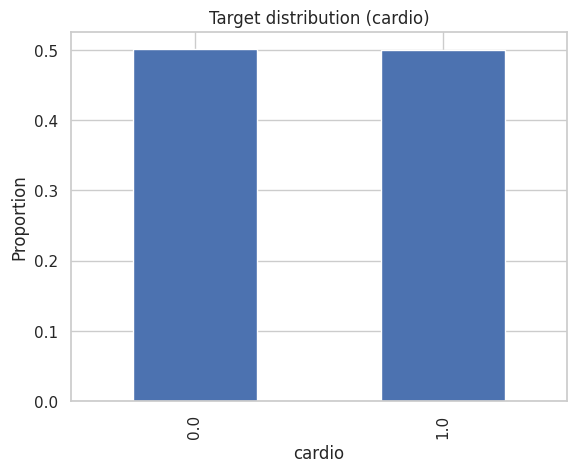

,proportion
cardio,
0.0,0.500961
1.0,0.499039


In [11]:
data["cardio"].value_counts(normalize=True).plot(kind="bar")
plt.title("Target distribution (cardio)")
plt.xlabel("cardio")
plt.ylabel("Proportion")
plt.show()

data["cardio"].value_counts(normalize=True)

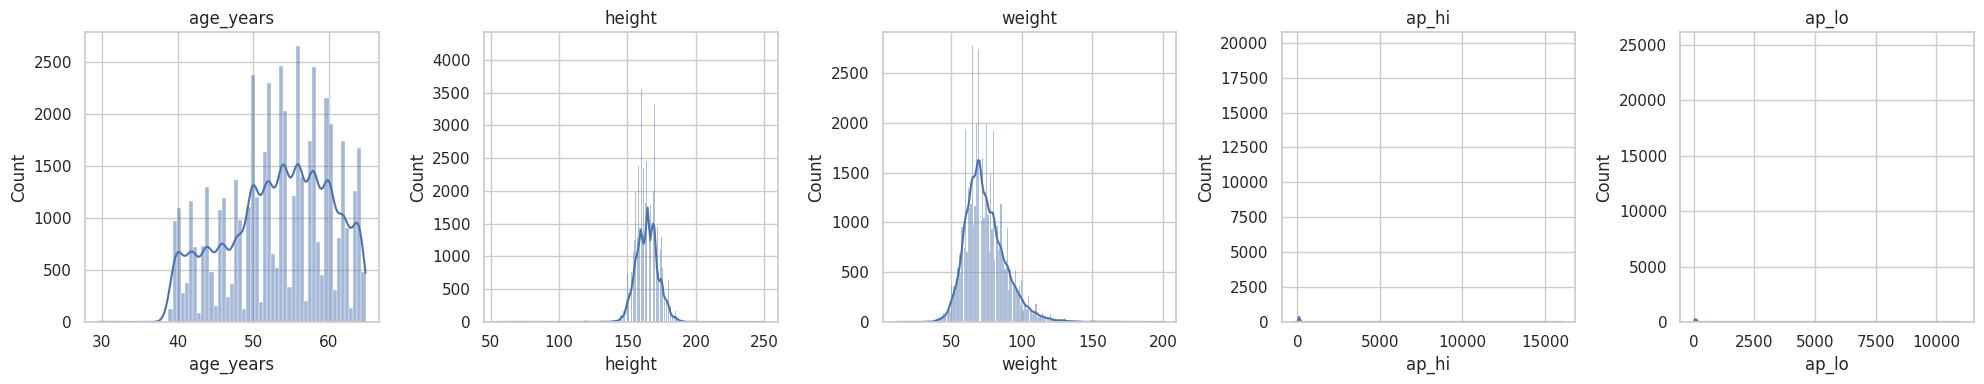

In [12]:
numeric_cols = ["age_years", "height", "weight", "ap_hi", "ap_lo"]
fig, axes = plt.subplots(1, len(numeric_cols), figsize=(20, 4))
for ax, col in zip(axes, numeric_cols):
    sns.histplot(data[col], kde=True, ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

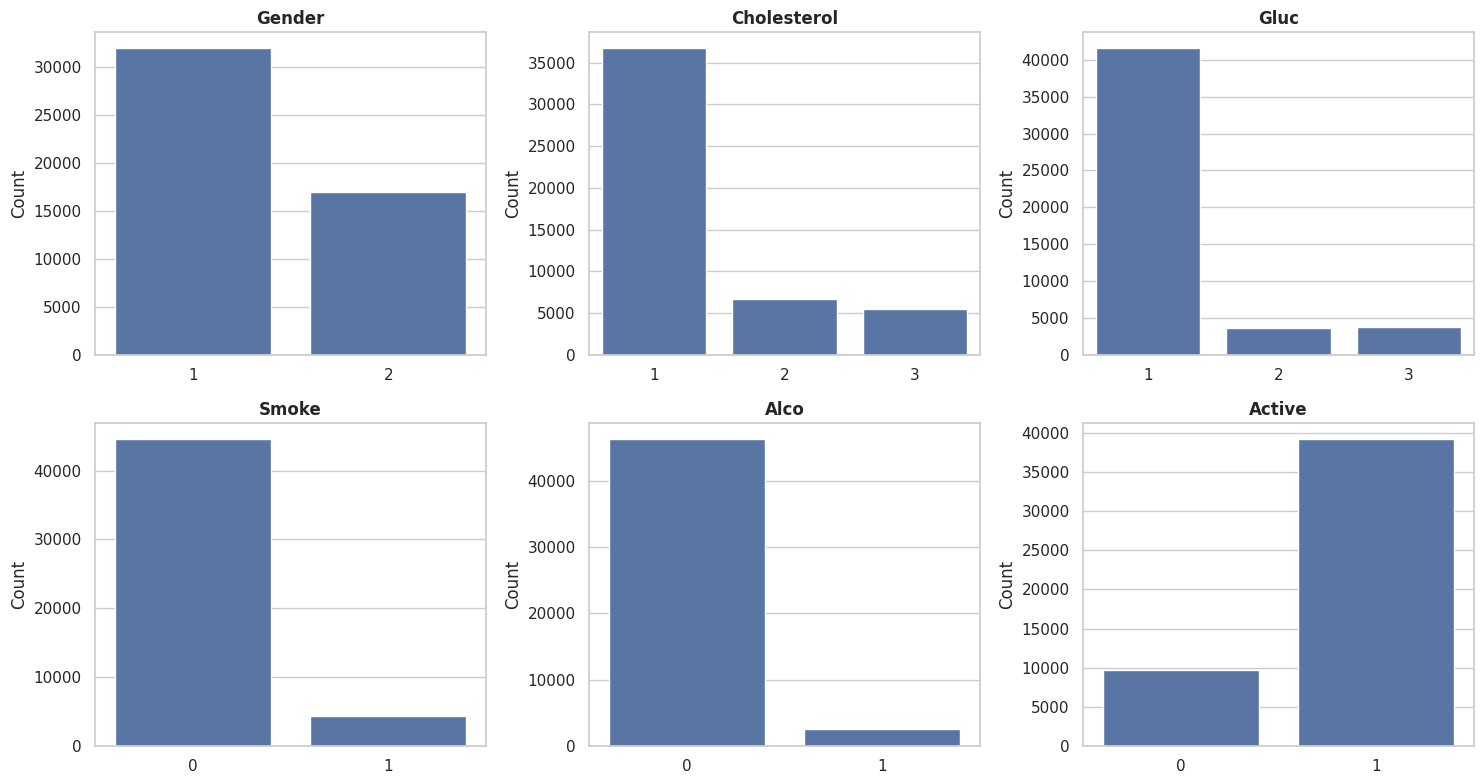

In [63]:
cat_cols = ["gender", "cholesterol", "gluc", "smoke", "alco", "active"]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for ax, col in zip(axes, cat_cols):
    sns.countplot(data=data, x=col, ax=ax)
    ax.set_title(col.capitalize(), fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

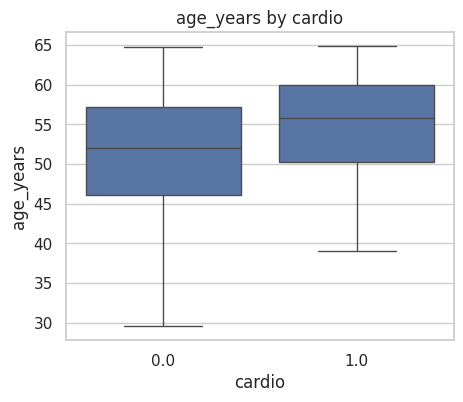

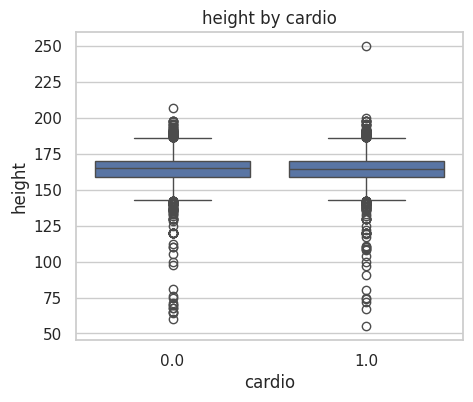

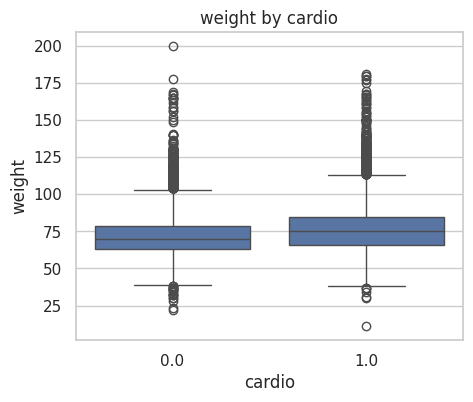

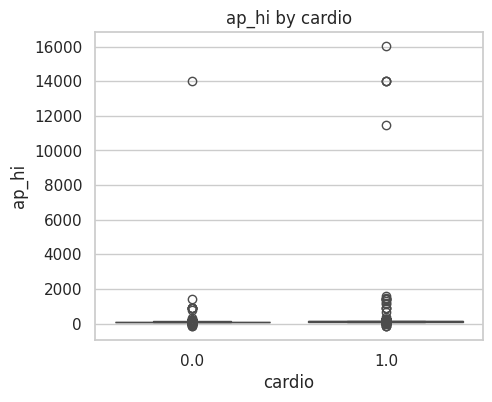

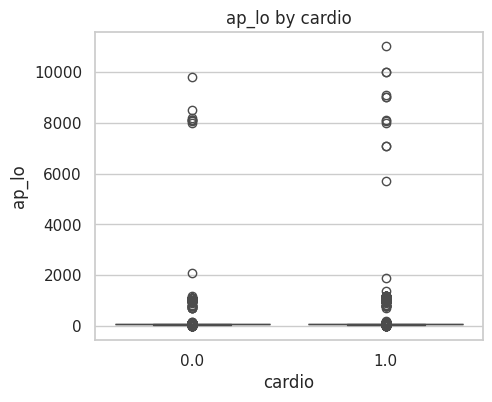


gender vs cardio:


cardio,0.0,1.0
gender,,
1,0.502345,0.497655
2,0.498356,0.501644



cholesterol vs cardio:


cardio,0.0,1.0
cholesterol,,
1,0.560465,0.439535
2,0.396828,0.603172
3,0.232952,0.767048



gluc vs cardio:


cardio,0.0,1.0
gluc,,
1,0.519726,0.480274
2,0.407680,0.592320
3,0.381503,0.618497



smoke vs cardio:


cardio,0.0,1.0
smoke,,
0,0.498035,0.501965
1,0.531200,0.468800



alco vs cardio:


cardio,0.0,1.0
alco,,
0,0.499810,0.500190
1,0.521364,0.478636



active vs cardio:


cardio,0.0,1.0
active,,
0,0.462677,0.537323
1,0.510374,0.489626


In [14]:
for col in numeric_cols:
    plt.figure(figsize=(5, 4))
    sns.boxplot(data=data, x="cardio", y=col)
    plt.title(f"{col} by cardio")
    plt.show()

for col in cat_cols:
    cross = pd.crosstab(data[col], data["cardio"], normalize="index")
    print(f"\n{col} vs cardio:")
    display(cross)

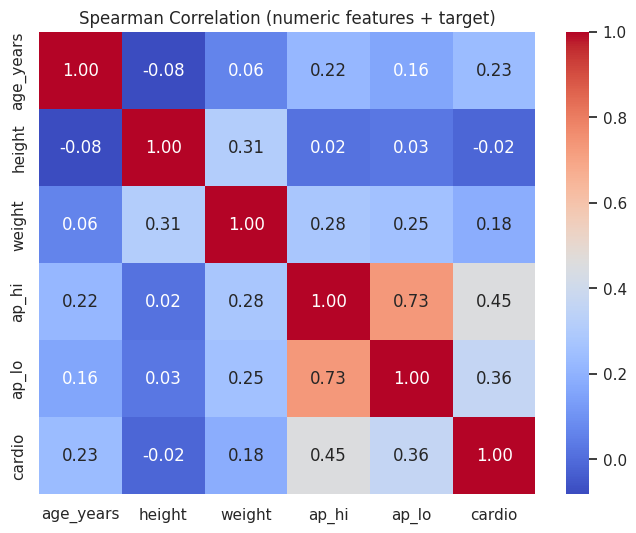

In [15]:
corr_cols = numeric_cols + ["cardio"]
corr = data[corr_cols].corr(method="spearman")

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Spearman Correlation (numeric features + target)")
plt.show()

In [16]:
print("Original shape:", data.shape)
data = data[(data["height"].between(120, 220)) &
            (data["weight"].between(30, 200))]
data = data[(data["ap_hi"].between(80, 240)) &
            (data["ap_lo"].between(40, 200)) &
            (data["ap_hi"] >= data["ap_lo"])]

print("Shape after cleaning:", data.shape)

Original shape: (49961, 14)
Shape after cleaning: (48966, 14)


#Data Cleaning :
The next cells remove or correct clearly invalid records, such as impossible heights and weights, unrealistic blood pressure values, and cases where systolic < diastolic. Age is converted from days to years, and missing values are handled (dropped or imputed as needed).
#Data Preprocessing :
Columns are organized into numeric, binary, ordinal, and categorical groups. An sklearn `ColumnTransformer` is defined to apply the right transformations to each type.
#Feature Engineering :
Clinically meaningful features are added:
  - `age_years`: human‑readable age.
  - `bmi`: body mass index from height and weight.
  - `high_ap_hi` and `high_ap_lo`: flags for high systolic/diastolic blood pressure.
  - `age_group`: categorical age ranges (e.g., <40, 40–60, 60+).
  These features capture patterns more strongly related to cardiovascular risk.
#Feature Selection :
After model training, feature importances from the Random Forest are used to identify which features contribute most to predictions, effectively selecting the most relevant attributes.
- **Scaling / Standardization (15):** Numeric features (age, height, weight, blood pressure, BMI) are standardized using `StandardScaler` inside a pipeline. This ensures models sensitive to scale (like logistic regression) work properly without data leakage.


In [17]:
data["age_years"] = data["age"] / 365.25

data["bmi"] = data["weight"] / ((data["height"] / 100) ** 2)

data["high_ap_hi"] = (data["ap_hi"] >= 140).astype(int)
data["high_ap_lo"] = (data["ap_lo"] >= 90).astype(int)

data["age_group"] = pd.cut(
    data["age_years"],
    bins=[0, 40, 60, 100],
    labels=["<40", "40-60", "60+"]
)

data[["age_years", "bmi", "high_ap_hi", "high_ap_lo", "age_group"]].head()

,age_years,bmi,high_ap_hi,high_ap_lo,age_group
0,50.357290,21.967120,0,0,40-60
1,55.381246,34.927679,1,1,40-60
2,51.627652,23.507805,0,0,40-60
3,48.249144,28.710479,1,1,40-60
4,47.841205,23.011177,0,0,40-60


In [18]:
print("Missing values per column after cleaning & FE:")
data.isnull().sum()

Missing values per column after cleaning & FE:


,0
id,0
age,0
gender,0
height,0
weight,0
ap_hi,0
ap_lo,0
cholesterol,0
gluc,0
smoke,0


In [19]:
before = data.shape[0]
data = data.dropna()
after = data.shape[0]

print(f"Dropped {before - after} rows due to NA. Final shape: {data.shape}")

Dropped 1 rows due to NA. Final shape: (48965, 18)


In [20]:
data_model = data.drop(columns=["id"])

X = data_model.drop("cardio", axis=1)
y = data_model["cardio"]

X.head()
y.head()

,cardio
0,0.0
1,1.0
2,1.0
3,1.0
4,0.0


In [21]:
numeric_features = ["age_years", "height", "weight", "ap_hi", "ap_lo", "bmi"]
binary_features = ["smoke", "alco", "active", "high_ap_hi", "high_ap_lo"]
ordinal_features = ["cholesterol", "gluc", "gender"]
categorical_features = ["age_group"]

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="passthrough"
)

print("Numeric features:", numeric_features)
print("Binary features (passthrough):", binary_features)
print("Ordinal features (passthrough):", ordinal_features)
print("Categorical (one-hot):", categorical_features)


Numeric features: ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi']
Binary features (passthrough): ['smoke', 'alco', 'active', 'high_ap_hi', 'high_ap_lo']
Ordinal features (passthrough): ['cholesterol', 'gluc', 'gender']
Categorical (one-hot): ['age_group']


In [22]:
ordered_cols = numeric_features + categorical_features + binary_features + ordinal_features
missing_cols = set(ordered_cols) - set(X.columns)
print("Missing in X:", missing_cols)

ordered_cols = [c for c in ordered_cols if c in X.columns]

X = X[ordered_cols]
X.head()

Missing in X: set()


,age_years,height,weight,ap_hi,ap_lo,bmi,age_group,smoke,alco,active,high_ap_hi,high_ap_lo,cholesterol,gluc,gender
0,50.357290,168,62.0,110,80,21.967120,40-60,0,0,1,0,0,1,1,2
1,55.381246,156,85.0,140,90,34.927679,40-60,0,0,1,1,1,3,1,1
2,51.627652,165,64.0,130,70,23.507805,40-60,0,0,0,0,0,3,1,1
3,48.249144,169,82.0,150,100,28.710479,40-60,0,0,1,1,1,1,1,2
4,47.841205,156,56.0,100,60,23.011177,40-60,0,0,0,0,0,1,1,1


#Baseline Modeling :
A simple majority‑class model and a logistic regression model are trained first. These baselines provide a minimum performance level that more complex models must beat.
#Data Splitting :
The dataset is split into training and test sets using a stratified split to preserve the original class distribution of `cardio`. The test set is held out for final unbiased evaluation.
#Model Selection :
Two main models are considered:
  - Logistic Regression (interpretable baseline).
  - Random Forest Classifier (non‑linear, typically stronger performance for tabular data).
  Both are wrapped in sklearn Pipelines that include preprocessing.
#Model Training :
Each model is trained on the training data with preprocessing applied inside the pipeline. Initial metrics on the test set show whether the models outperform the baselines.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

X_train.shape, X_test.shape

((39172, 15), (9793, 15))

In [24]:
from collections import Counter

majority_class = Counter(y_train).most_common(1)[0][0]
y_pred_majority = np.full_like(y_test, fill_value=majority_class)

print("Baseline majority-class accuracy:", accuracy_score(y_test, y_pred_majority))
print("Baseline majority-class F1:", f1_score(y_test, y_pred_majority))

Baseline majority-class accuracy: 0.505769427141836
Baseline majority-class F1: 0.0


In [25]:
log_reg = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, n_jobs=-1)
log_reg_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", log_reg)
])
log_reg_clf.fit(X_train, y_train)
y_pred_lr = log_reg_clf.predict(X_test)
y_proba_lr = log_reg_clf.predict_proba(X_test)[:, 1]

print("LogReg Accuracy:", accuracy_score(y_test, y_pred_lr))
print("LogReg Precision:", precision_score(y_test, y_pred_lr))
print("LogReg Recall:", recall_score(y_test, y_pred_lr))
print("LogReg F1:", f1_score(y_test, y_pred_lr))
print("LogReg ROC-AUC:", roc_auc_score(y_test, y_proba_lr))

LogReg Accuracy: 0.7220463596446441
LogReg Precision: 0.7743523316062176
LogReg Recall: 0.6175619834710744
LogReg F1: 0.6871264367816092
LogReg ROC-AUC: 0.7901407111142258


In [26]:
rf = RandomForestClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", rf)
])

rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))
print("RF Precision:", precision_score(y_test, y_pred_rf))
print("RF Recall:", recall_score(y_test, y_pred_rf))
print("RF F1:", f1_score(y_test, y_pred_rf))
print("RF ROC-AUC:", roc_auc_score(y_test, y_proba_rf))

RF Accuracy: 0.7082610027570714
RF Precision: 0.7165319938851278
RF Recall: 0.677892561983471
RF F1: 0.696676929610362
RF ROC-AUC: 0.7691015587848087


#Hyperparameter Tuning :
`GridSearchCV` or `RandomizedSearchCV` is used to search over Random Forest hyperparameters (e.g., number of trees, depth, min samples split/leaf) using cross‑validation with ROC‑AUC as the scoring metric.


In [27]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    "model__n_estimators": randint(100, 250),
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": randint(2, 15),
    "model__min_samples_leaf": randint(1, 5)
}

random_search = RandomizedSearchCV(
    rf_clf, param_distributions=param_dist,
    n_iter=15,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)
random_search.fit(X_train, y_train)
print("Best params:", random_search.best_params_)
print("Best CV ROC-AUC:", random_search.best_score_)

grid_search = random_search

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best params: {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4, 'model__n_estimators': 207}
Best CV ROC-AUC: 0.8015451177428675


#Model Evaluation :
he best model from the search is evaluated on the held‑out test set using accuracy, precision, recall, F1‑score, and ROC‑AUC. This quantifies how well the final model is expected to perform on unseen data.


In [40]:
best_model = grid_search.best_estimator_

y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_pred_best))
print("Test Precision:", precision_score(y_test, y_pred_best))
print("Test Recall:", recall_score(y_test, y_pred_best))
print("Test F1:", f1_score(y_test, y_pred_best))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba_best))

Test Accuracy: 0.7299091187582968
Test Precision: 0.7612473220661747
Test Recall: 0.6607438016528926
Test F1: 0.7074438668288906
Test ROC-AUC: 0.79521746149341


In [62]:
preprocessor = best_model.named_steps['preprocess']
rf_model = best_model.named_steps['model']

print("✅ Extracted components")

from sklearn.pipeline import Pipeline
cloud_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", rf_model)
])

cloud_pipeline.fit(X_train[:1000], y_train[:1000])
test_pred = cloud_pipeline.predict(X_test[:5])
print("✅ Cloud pipeline works:", test_pred)

import joblib
import os
os.makedirs("models", exist_ok=True)
joblib.dump(cloud_pipeline, "models/cardio_cloud_compatible.pkl", protocol=4, compress=3)

print("✅ Saved: models/cardio_cloud_compatible.pkl")
print(f"Size: {os.path.getsize('models/cardio_cloud_compatible.pkl') / 1024**2:.1f} MB")


✅ Extracted components
✅ Cloud pipeline works: [1. 0. 1. 0. 0.]
✅ Saved: models/cardio_cloud_compatible.pkl
Size: 0.8 MB


#Error Analysis :
The confusion matrix and ROC curve are examined to understand where the model makes mistakes, especially false negatives (patients with disease predicted as healthy). This highlights trade‑offs between recall and precision.
#Model Interpretation / Explainability :
Feature importances from the Random Forest are computed and plotted. These show which variables (e.g., age, blood pressure, BMI, cholesterol) the model relies on most to predict cardiovascular risk, which is important for clinical trust.
#Model Validation :
Cross‑validation scores (ROC‑AUC and F1) on the training set are computed to check the stability and generalization of the model beyond a single train/test split. Consistent CV and test results increase confidence in the model.


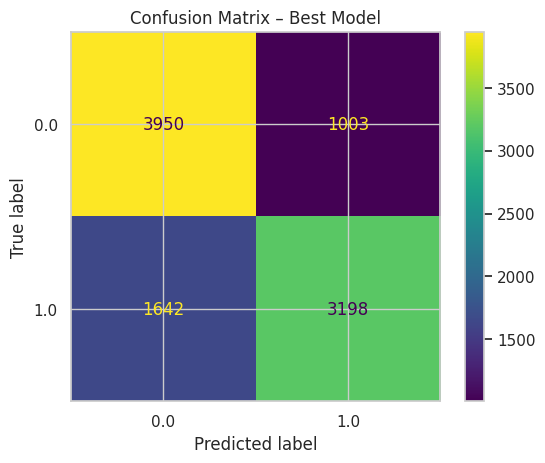

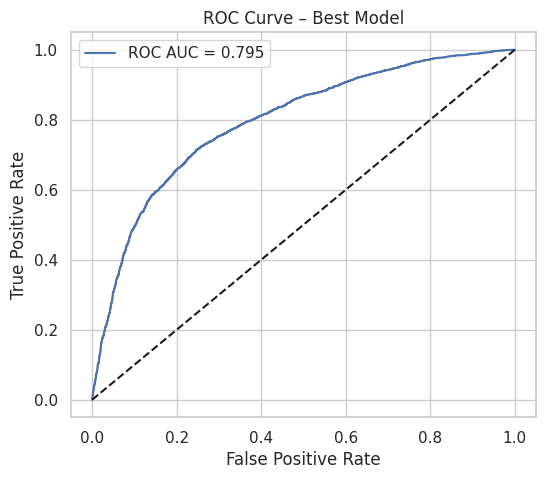

In [42]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best)
plt.title("Confusion Matrix – Best Model")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_proba_best)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_proba_best):.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Best Model")
plt.legend()
plt.show()


In [43]:
preprocessor.fit(X_train)
num_names = numeric_features
cat_names = list(preprocessor.named_transformers_["cat"]["onehot"].get_feature_names_out(categorical_features))
pass_through_names = binary_features + ordinal_features

all_feature_names = num_names + cat_names + pass_through_names

rf_step = best_model.named_steps["model"]
importances = rf_step.feature_importances_

feat_imp = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)
feat_imp.head(20)

,0
ap_hi,0.189125
age_years,0.177989
bmi,0.130319
weight,0.101787
high_ap_hi,0.083536
height,0.083083
ap_lo,0.067070
cholesterol,0.039659
high_ap_lo,0.033987
gluc,0.022219


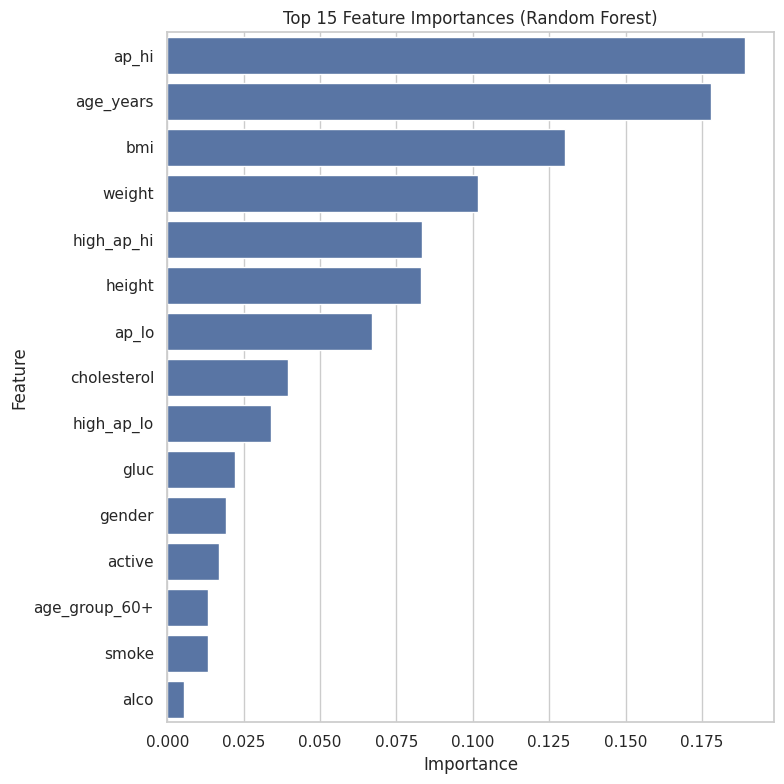

In [44]:
plt.figure(figsize=(8, 8))
sns.barplot(x=feat_imp.head(15), y=feat_imp.head(15).index)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [45]:
joblib.dump(best_model, "cardio_best_model.pkl")

loaded_model = joblib.load("cardio_best_model.pkl")
test_preds = loaded_model.predict(X_test)
print("Reloaded model F1:", f1_score(y_test, test_preds))

Reloaded model F1: 0.6928768636112645


#Packaging :
The full preprocessing + model pipeline is serialized with `joblib` into `cardio_best_model_v1.pkl`. This artifact can be loaded and used for inference without rerunning the entire notebook.
Version Control :
The project is structured into folders (data, notebooks, src, models, artifacts) with a `requirements.txt`. Git commands (init, add, commit, tag) are provided so each model version and code change can be tracked.
Documentation :
A `README.md` file is automatically generated summarizing the dataset, final metrics, chosen model, and saved artifacts. This serves as project‑level documentation for other team members and stakeholders.
Deployment :
  - A deployment‑ready `predict_cardio_for_patient()` function is implemented that accepts patient data (as a dictionary or JSON) and returns a prediction with risk probability.
  - An example Flask API sketch shows how the saved model could be exposed via a `/predict` endpoint in a real application.
#Monitoring :
Simple monitoring logic is implemented using Kolmogorov‑Smirnov tests on numeric features to detect data drift between training data and new incoming data.
#Performance Tracking :
Test metrics and drift reports are saved as JSON files, and (optionally) MLflow can be used to log metrics and model artifacts for experiment tracking.
#Model Retraining :
A retraining function is provided that refits the model on combined old and new data when significant drift is detected, and saves the retrained version.
#Maintenance :
The monitoring and retraining procedures form a maintenance loop: periodically check for drift and performance degradation, retrain when necessary, and save new model versions while keeping rollback capability.


In [53]:
import os
os.makedirs("model_artifacts", exist_ok=True)

import json
metrics = {
    "test_accuracy": float(accuracy_score(y_test, y_pred_best)),
    "test_precision": float(precision_score(y_test, y_pred_best)),
    "test_recall": float(recall_score(y_test, y_pred_best)),
    "test_f1": float(f1_score(y_test, y_pred_best)),
    "test_roc_auc": float(roc_auc_score(y_test, y_proba_best)),
    "best_params": grid_search.best_params_
}

with open("model_artifacts/metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Metrics logged to model_artifacts/metrics.json")
print(metrics)

Metrics logged to model_artifacts/metrics.json
{'test_accuracy': 0.7299091187582968, 'test_precision': 0.7612473220661747, 'test_recall': 0.6607438016528926, 'test_f1': 0.7074438668288906, 'test_roc_auc': 0.79521746149341, 'best_params': {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4, 'model__n_estimators': 207}}


In [54]:
def predict_cardio_for_patient(model, patient_dict):
    """
    Takes a dict of patient features and returns prediction + probability.
    Keys must match columns in X (same names and types).
    """
    df = pd.DataFrame([patient_dict])
    df = df[X.columns]

    proba = model.predict_proba(df)[:, 1][0]
    pred = int(proba >= 0.5)

    return pred, float(proba)


In [60]:
import os
import textwrap

os.makedirs("models", exist_ok=True)
os.makedirs("model_artifacts", exist_ok=True)
joblib.dump(best_model, "models/cardio_cloud_compatible.pkl")
feature_cols = list(X.columns)
joblib.dump(feature_cols, "model_artifacts/feature_columns.pkl")
print(f"✅ Saved model and {len(feature_cols)} feature columns")
app_code = '''import streamlit as st
import pandas as pd
import joblib

# Load model and feature columns
@st.cache_resource
def load_model():
    model = joblib.load("models/cardio_cloud_compatible.pkl")
    feature_cols = joblib.load("model_artifacts/feature_columns.pkl")
    return model, feature_cols

model, feature_cols = load_model()

st.title("🫀 Cardiovascular Disease Risk Prediction")
st.markdown("*Enter patient information to get instant risk assessment*")

# Sidebar inputs
st.sidebar.header("👤 Patient Information")

age_years = st.sidebar.slider("Age (years)", 18, 90, 50)
height = st.sidebar.slider("Height (cm)", 140, 210, 170)
weight = st.sidebar.slider("Weight (kg)", 40, 150, 75)
ap_hi = st.sidebar.slider("Systolic BP (mmHg)", 80, 240, 120)
ap_lo = st.sidebar.slider("Diastolic BP (mmHg)", 40, 200, 80)

# Calculated features
bmi = weight / ((height / 100) ** 2)
high_ap_hi = 1 if ap_hi >= 140 else 0
high_ap_lo = 1 if ap_lo >= 90 else 0

# Categorical inputs
age_group = st.sidebar.selectbox("Age Group", ["<40", "40-60", "60+"])
gender = st.sidebar.selectbox("Gender", ["Female (1)", "Male (2)"])
gender = int(gender.split("(")[1].split(")")[0])
smoke = st.sidebar.selectbox("Smokes?", ["No (0)", "Yes (1)"])
smoke = int(smoke.split("(")[1].split(")")[0])
alco = st.sidebar.selectbox("Alcohol?", ["No (0)", "Yes (1)"])
alco = int(alco.split("(")[1].split(")")[0])
active = st.sidebar.selectbox("Physically active?", ["No (0)", "Yes (1)"])
active = int(active.split("(")[1].split(")")[0])
cholesterol = st.sidebar.selectbox("Cholesterol", ["Normal (1)", "Above Normal (2)", "Well Above Normal (3)"])
cholesterol = int(cholesterol.split("(")[1].split(")")[0])
gluc = st.sidebar.selectbox("Glucose", ["Normal (1)", "Above Normal (2)", "Well Above Normal (3)"])
gluc = int(gluc.split("(")[1].split(")")[0])

# Predict button
if st.button("🔮 Predict Risk", type="primary"):
    # Create input matching exact training features
    input_data = {
        "age_years": float(age_years),
        "height": float(height),
        "weight": float(weight),
        "ap_hi": float(ap_hi),
        "ap_lo": float(ap_lo),
        "bmi": float(bmi),
        "age_group": age_group,
        "smoke": int(smoke),
        "alco": int(alco),
        "active": int(active),
        "high_ap_hi": int(high_ap_hi),
        "high_ap_lo": int(high_ap_lo),
        "cholesterol": int(cholesterol),
        "gluc": int(gluc),
        "gender": int(gender),
    }

    # CRITICAL: Use saved feature_cols for correct column ordering
    input_df = pd.DataFrame([input_data])[feature_cols]

    # Predict
    try:
        risk_proba = model.predict_proba(input_df)[:, 1][0]
        prediction = int(risk_proba >= 0.5)

        # Display result
        st.subheader("📊 Prediction Results")

        col1, col2 = st.columns([1, 2])
        with col1:
            if prediction == 1:
                st.error("⚠️ **HIGH RISK**")
            else:
                st.success("✅ **LOW RISK**")

        with col2:
            st.metric("Disease Probability", f"{risk_proba:.1%}")

        # Risk interpretation
        if risk_proba >= 0.7:
            st.warning("🚨 **Very High Risk**: Immediate medical consultation recommended")
        elif risk_proba >= 0.5:
            st.warning("⚠️ **Elevated Risk**: Consider scheduling a checkup")
        elif risk_proba >= 0.3:
            st.info("ℹ️ **Moderate Risk**: Monitor health indicators regularly")
        else:
            st.success("✅ **Low Risk**: Maintain healthy lifestyle")

        # Show input data
        with st.expander("📋 View Input Data"):
            st.dataframe(input_df, use_container_width=True)

    except Exception as e:
        st.error(f"❌ Prediction error: {str(e)}")

st.markdown("---")
st.caption("⚕️ Powered by scikit-learn Random Forest | For educational purposes only - not medical advice")
'''

with open("app.py", "w") as f:
    f.write(app_code.strip())

print("✅ app.py created successfully (NameError fixed)!")


✅ Saved model and 15 feature columns
✅ app.py created successfully (NameError fixed)!


In [56]:
cv_scores = cross_val_score(
    best_model,
    X_train, y_train,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

print("CV ROC-AUC scores:", cv_scores)
print(f"Mean CV ROC-AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

cv_f1_scores = cross_val_score(
    best_model,
    X_train, y_train,
    cv=5,
    scoring="f1",
    n_jobs=-1
)
print(f"Mean CV F1: {cv_f1_scores.mean():.4f} ± {cv_f1_scores.std():.4f}")

CV ROC-AUC scores: [0.80090358 0.79845769 0.8074626  0.79869885 0.80289947]
Mean CV ROC-AUC: 0.8017 ± 0.0033
Mean CV F1: 0.7170 ± 0.0036


In [61]:
def detect_data_drift(X_ref, X_new, columns=None, ks_threshold=0.1):
    """Detect data drift using Kolmogorov-Smirnov test"""
    if columns is None:
        columns = [c for c in X_ref.columns if X_ref[c].dtype in ("int64", "float64")]

    drift_report = {}
    for col in columns:
        stat, p_value = ks_2samp(X_ref[col], X_new[col])
        drift_report[col] = {
            "ks_statistic": float(stat),
            "p_value": float(p_value),
            "drifted": bool(stat > ks_threshold)
        }

    drifted_cols = [c for c, v in drift_report.items() if v["drifted"]]
    print(f"\n🔍 Drift Detection: {len(drifted_cols)}/{len(columns)} features drifted")
    if drifted_cols:
        print(f"Drifted features: {drifted_cols}")

    return drift_report

numeric_cols = [c for c in X_train.columns if X_train[c].dtype in ("int64", "float64")]
drift_report = detect_data_drift(X_train, X_test, columns=numeric_cols)

with open("model_artifacts/drift_report.json", "w") as f:
    json.dump(drift_report, f, indent=2)
print("✅ Drift report saved")
def retrain_model_if_drift(X_old, y_old, X_new, y_new, model, ks_threshold=0.1):
    """Retrain model if significant drift is detected"""
    report = detect_data_drift(X_old, X_new, ks_threshold=ks_threshold)

    if any(v["drifted"] for v in report.values()):
        print("\n⚠️ Data drift detected → Retraining model...")
        X_combined = pd.concat([X_old, X_new], axis=0)
        y_combined = pd.concat([y_old, y_new], axis=0)
        model.fit(X_combined, y_combined)
        joblib.dump(model, "models/cardio_model_retrained.pkl")
        print("✅ Retrained model saved")
        return model, True
    else:
        print("\n✅ No significant drift detected")
        return model, False



🔍 Drift Detection: 0/14 features drifted
✅ Drift report saved


#Reporting & Communication :
 The final cells create an executive summary table and a README containing key metrics, artifacts, and model insights (top risk factors). These outputs are suitable for inclusion in reports or presentations.
#Stakeholder Review & Sign-off :
 The summary highlights model performance, key features, and deployment readiness in non-technical language. This allows stakeholders (e.g., doctors and managers) to review whether the model meets their expectations and risk tolerance.
#Iteration & Improvement :
 The notebook documents potential next steps, such as incorporating additional clinical features, exploring other model families, or refining drift detection. With version control and clear documentation in place, future iterations can build on this version systematically.


In [58]:
print("\n" + "="*50)
print("🏆 EXECUTIVE SUMMARY")
print("="*50)

y_proba_best = best_model.predict_proba(X_test)[:, 1]
y_pred_best = best_model.predict(X_test)

summary = pd.DataFrame({
    "Stage": [
        "Data Quality",
        "Model Performance",
        "Deployment",
        "Monitoring",
        "Retraining Strategy"
    ],
    "Status": [
        f"✅ Clean dataset: {X_train.shape[0]:,} train + {X_test.shape[0]:,} test rows",
        f"✅ ROC-AUC={roc_auc_score(y_test, y_proba_best):.3f} | F1={f1_score(y_test, y_pred_best):.3f}",
        f"✅ Model saved + Streamlit app generated (app.py)",
        f"✅ KS drift detection implemented ({len(numeric_cols)} numeric features)",
        f"✅ Auto-retrain on drift detection (threshold=0.1)"
    ]
})

display(summary)

print("\n📈 Top Risk Factors (Feature Importance)")
if hasattr(best_model, 'feature_importances_'):
    feat_imp = pd.Series(
        best_model.feature_importances_,
        index=feature_cols
    ).sort_values(ascending=False)

    for i, (feature, importance) in enumerate(feat_imp.head(8).items(), 1):
        print(f"{i}. {feature}: {importance:.4f}")


🏆 EXECUTIVE SUMMARY


,Stage,Status
0,Data Quality,"✅ Clean dataset: 39,172 train + 9,793 test rows"
1,Model Performance,✅ ROC-AUC=0.779 | F1=0.693
2,Deployment,✅ Model saved + Streamlit app generated (app.py)
3,Monitoring,✅ KS drift detection implemented (14 numeric f...
4,Retraining Strategy,✅ Auto-retrain on drift detection (threshold=0.1)



📈 Top Risk Factors (Feature Importance)


In [59]:

requirements = """
# Core data science libraries (your notebook uses these)
pandas>=2.0.0
numpy>=1.24.0
scikit-learn>=1.3.0
joblib>=1.3.0

# Visualization (for EDA in notebook)
matplotlib>=3.7.0
seaborn>=0.12.0

# Streamlit deployment
streamlit>=1.28.0

# Optional: MLflow tracking (if you used it)
# mlflow>=2.8.0
"""

with open("requirements.txt", "w") as f:
    f.write(requirements.strip())

print("✅ requirements.txt created!")
print("\n" + "="*50)
print(open("requirements.txt").read())
print("="*50)
print("\n📋 To install:")
print("pip install -r requirements.txt")


✅ requirements.txt created!

# Core data science libraries (your notebook uses these)
pandas>=2.0.0
numpy>=1.24.0
scikit-learn>=1.3.0
joblib>=1.3.0

# Visualization (for EDA in notebook)
matplotlib>=3.7.0
seaborn>=0.12.0

# Streamlit deployment
streamlit>=1.28.0

# Optional: MLflow tracking (if you used it)
# mlflow>=2.8.0

📋 To install:
pip install -r requirements.txt
